In [1]:
from are import build_steady_state_model, build_model
from parameters import are_parameters, F_to_K
from symengine import Function, Symbol 
from sympy import symbols, Eq, linsolve
import numpy as np 
import matplotlib.pyplot as plt

In this notebook, we compute the analytical steady state solution for the ARE system, fixing the neutron population and resultant power generation to 1.0 and 2.10 MW respectively. By fixing the neutron population, the point kinetics and the thermal hydraulics models become decoupled, and fully determined.  `build_steady_state_model()` constructs a model without delays, and with fixed power generation. We can then use a symbolic solver to solve the expressions. 

In [2]:
hA_param_set = 'baseline'
# hA_param_set = 'empirical'
# hA_param_set = 'leastsq'

alpha_param_set = 'baseline'
# alpha_param_set = 'OpenMC'
# alpha_param_set = 'leastsq'

params = are_parameters(hA_param_set, alpha_param_set)
ARE_ss = build_steady_state_model(params)

This step substitutes the `current_y` objects from JiTCDDE, with symbols that can be interpreted by sympy's `linsolve()`.

In [3]:
# conver to sympy exprssions
subs = {Function("current_y")(i): Symbol(f"y{i}") for i in range(len(ARE_ss.nodes))}
exprs_subbed = [expr.subs(subs) for expr in ARE_ss.dydt]
precursor_system = exprs_subbed[7:13]
temp_system = exprs_subbed[:6] + exprs_subbed[14:]

In [4]:
# solve each system (temps and precursors)
ys = symbols(f'y0:{54}')
ys_precursors = ys[7:13]
ys_temp = ys[:6] + ys[14:]

eqns_precursors = [Eq(expr, 0) for expr in precursor_system]
eqns_temps = [Eq(expr, 0) for expr in temp_system]

sol_precursors = linsolve(eqns_precursors, ys_precursors)
sol_temps = linsolve(eqns_temps, ys_temp)

# unpack
sol_tuple_precursors = next(iter(sol_precursors))
sol_tuple_temps = next(iter(sol_temps))
sol_list_precursors = list(sol_tuple_precursors)
sol_list_temps = list(sol_tuple_temps)

# add the fixed variables to the precursor solution
sol_list_precursors = [params['n_frac0']] + sol_list_precursors + [params['rho_0']]

Now we can use the computed steady state as an initial condition for the full dynamic model to confirm an equilibrium state. 

In [5]:
# build model with computed steady state condition
ARE_dynamic = build_model(params)
y0_analytical = sol_list_temps[:6] + sol_list_precursors + sol_list_temps[6:]

for idx, n in enumerate(ARE_dynamic.nodes):
    ARE_dynamic.nodes[n].y0 = y0_analytical[idx]

# solve
T = np.arange(0,30,1.0)
sol = ARE_dynamic.solve(T,
                        max_delay = params['tau_l'], 
                        populate_nodes = True, 
                        md_step = 0.0001, 
                        abs_tol = 1.0e-12, 
                        rel_tol = 5.0e-8,)

finalizing integrator...
integrating...


Integration progress:   0%|          | 0/30 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress: 100%|██████████| 30/30 [00:02<00:00, 14.09it/s]

populating nodes objects solution vectors...


Below we see that the computed steady-state indeed leads to an equilbrium condition, from which we can compare to the experimental equilibrium state.

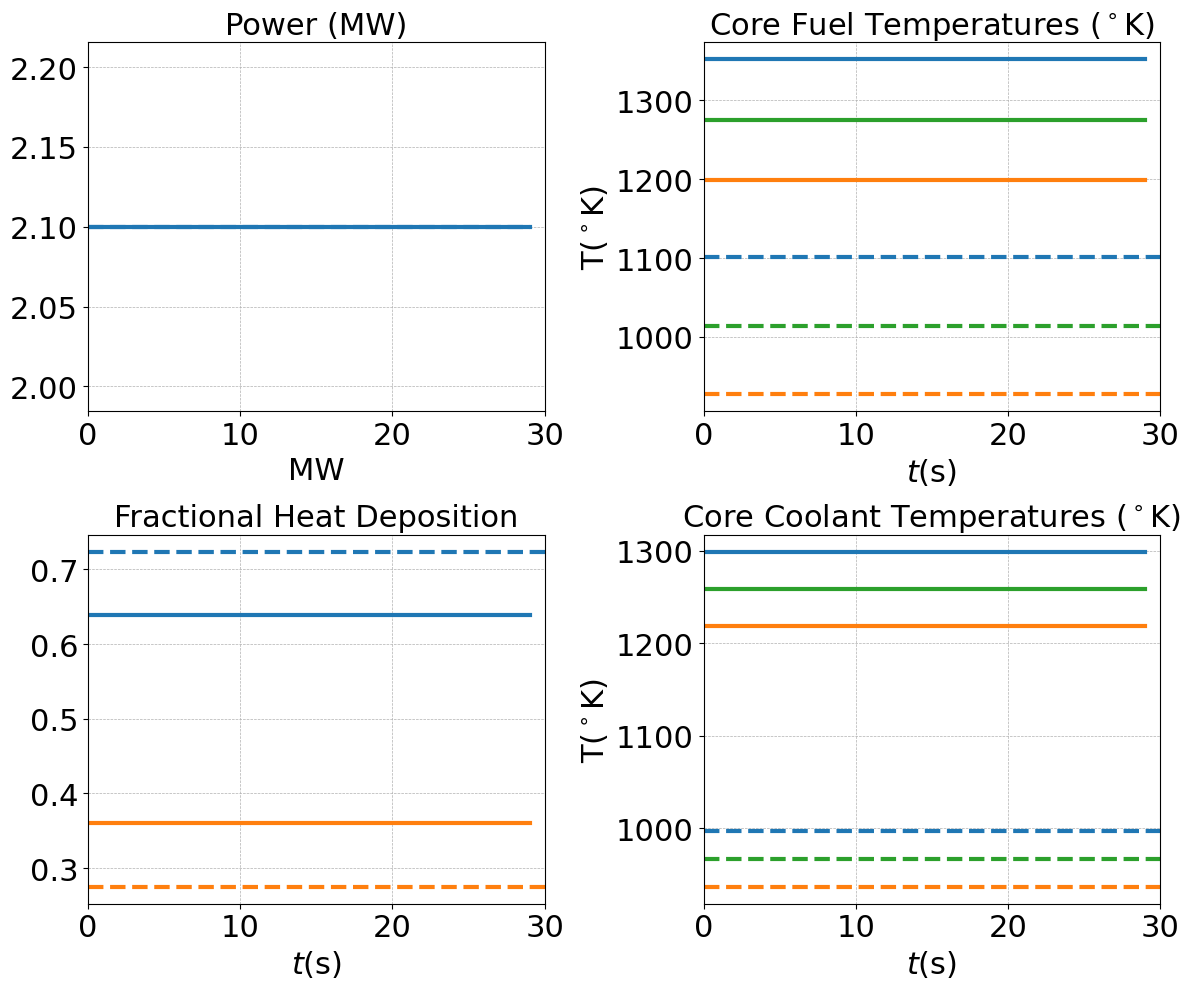

In [6]:
fig,axs = plt.subplots(2,2,figsize=(12,10))

t_0 = 0.0
t_f = 30

# Set a professional color scheme
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
          'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

tls = 22
# Function to update the style of each axis
def update_axis_style(ax, title = '', x_label='', y_label='', x_ticks=True, y_scale='linear'):
    ax.set_xlim([t_0, t_f])
    ax.set_title(title,fontsize=tls)
    ax.set_xlabel(x_label,fontsize=tls)
    ax.set_ylabel(y_label,fontsize=tls)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks,labelsize = tls)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,labelsize = tls)
    ax.set_yscale(y_scale)

lw = 3
# power
update_axis_style(axs[0,0], 'Power (MW)', "MW")
axs[0,0].plot(T,params['P']*ARE_dynamic.nodes['n'].y_out,color=colors[0],linewidth=lw)
axs[0,0].plot(T,params['P']*np.ones(len(T)),linestyle='--',color=colors[0],linewidth=lw)

# Core Node Temperatures
update_axis_style(axs[0,1], r"Core Fuel Temperatures ($^\circ$K)")
axs[0,1].set_xlim([t_0,t_f])
axs[0,1].plot(T,[s[ARE_dynamic.nodes['c_f2'].index] for s in sol],label="fuel outlet, msrDynamics",color=colors[0],linewidth=lw) 
axs[0,1].axhline(y=F_to_K(1522),label="fuel outlet, ORNL-1845",linestyle="--",color=colors[0],linewidth=lw) 
axs[0,1].plot(T,[(s[ARE_dynamic.nodes['hx_fh1_f2'].index]+s[ARE_dynamic.nodes['hx_fh2_f2'].index])/2 for s in sol],label="fuel inlet, msrDynamics",color=colors[1],linewidth=lw) 
axs[0,1].axhline(y=F_to_K(1209),label="fuel inlet, ORNL-1845",linestyle="--",color=colors[1],linewidth=lw) 
axs[0,1].plot(T,[(s[ARE_dynamic.nodes['c_f2'].index]+(s[ARE_dynamic.nodes['hx_fh1_f2'].index]+s[ARE_dynamic.nodes['hx_fh2_f2'].index])/2)/2 for s in sol],label="Mean, msrDynamics",color=colors[2],linewidth=lw) 
axs[0,1].axhline(y=(F_to_K(1522)+F_to_K(1209))/2,label="Mean, ORNL-1845",linestyle="--",color=colors[2],linewidth=lw) 
axs[0,1].set_xlabel(r"$t$(s)")
axs[0,1].set_ylabel(r"T($^\circ$K)")
# axs[0].legend()

# Core Node Temperatures
update_axis_style(axs[1,1], r"Core Coolant Temperatures ($^\circ$K)")
axs[1,1].set_xlim([t_0,t_f])
axs[1,1].plot(T,[s[ARE_dynamic.nodes['c_c2'].index] for s in sol],label="coolant outlet, msrDynamics",color=colors[0],linewidth=lw) 
axs[1,1].axhline(y=F_to_K(1335),label="coolant outlet, ORNL-1845",linestyle="--",color=colors[0],linewidth=lw) 
axs[1,1].plot(T,[(s[ARE_dynamic.nodes['hx_ch1_c2'].index]+s[ARE_dynamic.nodes['hx_ch2_c2'].index])/2 for s in sol],label="coolant inlet, msrDynamics",color=colors[1],linewidth=lw) 
axs[1,1].axhline(y=F_to_K(1226),label="coolant inlet, ORNL-1845",linestyle="--",color=colors[1],linewidth=lw) 
axs[1,1].plot(T,[(s[ARE_dynamic.nodes['c_c2'].index]+(s[ARE_dynamic.nodes['hx_ch1_c2'].index]+s[ARE_dynamic.nodes['hx_ch2_c2'].index])/2)/2 for s in sol],label="Mean, msrDynamics",color=colors[2],linewidth=lw) 
axs[1,1].axhline(y=(F_to_K(1335)+F_to_K(1226))/2,label="Mean, ORNL-1845",linestyle="--",color=colors[2],linewidth=lw) 
axs[1,1].set_xlabel(r"$t$(s)")
axs[1,1].set_ylabel(r"T($^\circ$K)")
# axs[1,1].legend()

# Core Node Temperatures
update_axis_style(axs[1,0], r"Fractional Heat Deposition")
axs[1,0].set_xlim([t_0,t_f])
axs[1,0].axhline(y=1.52/2.1,label="Fractional Power Extraction: Fuel, ORNL",linestyle="--",color=colors[0],linewidth=lw)
axs[1,0].plot(T,[(s[ARE_dynamic.nodes['c_f2'].index]-(s[ARE_dynamic.nodes['hx_fh1_f2'].index]+s[ARE_dynamic.nodes['hx_fh2_f2'].index])/2)*params['W_f']*params['scp_f']/(params['P']*s[ARE_dynamic.nodes['n'].index]) for s in sol],label="Fractional Power Extraction: Fuel, msrDynamics",linewidth=lw) 
axs[1,0].axhline(y=0.577/2.1,label="Fractional Power Extraction: Coolant, ORNL",linestyle="--",color=colors[1],linewidth=lw)
axs[1,0].plot(T,[(s[ARE_dynamic.nodes['c_c2'].index]-(s[ARE_dynamic.nodes['hx_ch1_c2'].index]+s[ARE_dynamic.nodes['hx_ch2_c2'].index])/2)*params['W_c']*params['scp_c']/(params['P']*s[ARE_dynamic.nodes['n'].index]) for s in sol],label="Fractional Power Extraction: Coolant, msrDynamics",color=colors[1],linewidth=lw) 
axs[1,0].set_xlabel(r"$t$(s)")
# axs[1,0].legend()


fig.tight_layout()

Here we print some metrics, and how much they deviate from the ORNL data. 

In [7]:
power = 2.10 * ARE_dynamic.nodes['n'].y_out[-1]
dT_fuel = ARE_dynamic.nodes['c_f2'].y_out[-1] - (ARE_dynamic.nodes['hx_fh1_f2'].y_out[-1] + ARE_dynamic.nodes['hx_fh2_f2'].y_out[-1]) / 2
dT_coolant = ARE_dynamic.nodes['c_c2'].y_out[-1] - (ARE_dynamic.nodes['hx_ch1_c2'].y_out[-1] + ARE_dynamic.nodes['hx_ch2_c2'].y_out[-1]) / 2
Q_fuel = params['scp_f'] * params['W_f'] * dT_fuel
Q_coolant = params['scp_c'] * params['W_c'] * dT_coolant
Q_fuel_pct = Q_fuel / power
Q_coolant_pct = Q_coolant / power

power_ORNL = 2.10
dT_fuel_ORNL = 174
dT_coolant_ORNL = 61
Q_fuel_ORNL = 1.52
Q_coolant_ORNL = 0.58
Q_fuel_pct_ORNL = Q_fuel_ORNL / power_ORNL
Q_coolant_pct_ORNL = Q_coolant_ORNL / power_ORNL

def pct_diff(sim, ref):
    return (sim - ref) / ref

print(f"power:         {power}")
print(f"dT fuel:       {dT_fuel}")
print(f"dT coolant:    {dT_coolant}")
print(f"Q_fuel:        {Q_fuel}")
print(f"Q_fuel pct:    {Q_fuel_pct}")
print(f"Q_coolant:     {Q_coolant}")
print(f"Q_coolant pct: {Q_coolant_pct}")
print()
print(f"delta P:      {pct_diff(power, power_ORNL)}")
print(f"delta dTf:    {pct_diff(dT_fuel, dT_fuel_ORNL)}")
print(f"delta dTc:    {pct_diff(dT_coolant, dT_coolant_ORNL)}")
print(f"delta Qf:     {pct_diff(Q_fuel, Q_fuel_ORNL)}")
print(f"delta Qf_pct: {pct_diff(Q_fuel_pct, Q_fuel_pct_ORNL)}")
print(f"delta Qc:     {pct_diff(Q_coolant, Q_coolant_ORNL)}")
print(f"delta Qc_pct: {pct_diff(Q_coolant_pct, Q_coolant_pct_ORNL)}")

power:         2.1
dT fuel:       153.51575450848577
dT coolant:    80.85811502595152
Q_fuel:        1.3425316143237707
Q_fuel pct:    0.639300768725605
Q_coolant:     0.757468385676278
Q_coolant pct: 0.3606992312744181

delta P:      0.0
delta dTf:    -0.11772554880180591
delta dTc:    0.3255428692778938
delta Qf:     -0.11675551689225615
delta Qf_pct: -0.11675551689225618
delta Qc:     0.3059799753039278
delta Qc_pct: 0.3059799753039278
